# Specific Dynamic Feature improving the performance of a model

## Init

In [1]:
import os

path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find('project')
# slice the path from the index of 'project' to the end
project_path = path[:index_project+7]
# set the working directory
os.chdir(project_path+'\\src')
print(f'Project path set to: {os.getcwd()}')

Project path set to: c:\Github\new-peak-project\src


In [2]:
from dotenv import dotenv_values
config = dotenv_values(".env")
print(config["DATA_PATH"])

I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\new-peak-project\experiments


In [3]:
from models.ModelBuilder import ModelBuilder
from models.Reaction import Reaction
from models.ReactionArchtype import ReactionArchtype
from models.ArchtypeCollections import *

# import scikit-learn
from sklearn.linear_model import LinearRegression
# tree models and support vector machines
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
# import pearson correlation
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from copy import deepcopy

## Notebook Parameters

In [4]:
import os 

### parameters 

notebook_name = 'exp7_drug_model' # name of the notebook

## Generation of ground truth model 

model_name = 'v3_large_model_50_20'
o_random_seed = 1
p_random_seed = 2
no_observable_species = 100
no_feedback_regulations = 20
specie_value_range = (1000, 5000)
param_range = (0.05, 20)
param_multiplier_range = (0.5, 1.5)


## Simulation parameters 

simulation_time = 1000 
simulation_step = 100

## Feature data generation 

feature_generation_method = 'lhs'
feature_generation_extra_params = {'min': 0.1, 'max': 10}
feature_generation_size = 1000 
feature_generation_seed = 50 # if -1 then 'o_random_seed' is used
if feature_generation_seed == -1:
    feature_generation_seed = o_random_seed
    
## Data engineering parameters

# Suboptimal Model Generation 

'''
Options: 
- 'feedback_prune': removes feedback regulations from the model 
- 'random parameter': randomizes a x% of parameter values of the model
'''

''' 
Options: 
- 'last_time_point' : only the last time point of the phosphorylated species is used
- 'dynamic_feature': computes the characteristic 'ten' dynamic feature for each specie data 
'''

## General parameters
parallelise = True
save_figures = True 
experiment_id = notebook_name + '_' + str(o_random_seed) + '_' + str(p_random_seed) + '_' + str(feature_generation_seed)
experiment_folder = config['DATA_PATH'] + '/' + experiment_id + '/'
if not os.path.exists(experiment_folder):
    os.makedirs(experiment_folder)
    
print(experiment_folder)

I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\new-peak-project\experiments/exp7_drug_model_1_2_50/


## Analysis

### Virtual Cell Creation

In [5]:
# create a drug enabled model 
from models.Utils import *
from models.DrugModelSpecification import DrugModelSpecification, Drug

model_drug_spec = DrugModelSpecification()
model_drug_spec.generate_specifications(o_random_seed, no_observable_species, no_feedback_regulations, verbose=0)
drug_0 = Drug('D0', 500, 500)
np.random.seed(o_random_seed)
# add random 'up' and 'down' regulations to the drug
regulation_dir = []
for i, s in enumerate(model_drug_spec.A_species):
    regulation_dir.append(np.random.choice(['up', 'down']))
    drug_0.add_regulation(s, 'up')
model_drug_spec.add_drug(drug_0)
print(model_drug_spec)
print(f'Feedback: {model_drug_spec.get_feedback_regulations()}')

A Species: ['A0', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A21', 'A22', 'A23', 'A24', 'A25', 'A26', 'A27', 'A28', 'A29', 'A30', 'A31', 'A32', 'A33', 'A34', 'A35', 'A36', 'A37', 'A38', 'A39', 'A40', 'A41', 'A42', 'A43', 'A44', 'A45', 'A46', 'A47', 'A48', 'A49', 'A50', 'A51', 'A52', 'A53', 'A54', 'A55', 'A56', 'A57', 'A58', 'A59', 'A60', 'A61', 'A62', 'A63', 'A64', 'A65', 'A66', 'A67', 'A68', 'A69', 'A70', 'A71', 'A72', 'A73', 'A74', 'A75', 'A76', 'A77', 'A78', 'A79', 'A80', 'A81', 'A82', 'A83', 'A84', 'A85', 'A86', 'A87', 'A88', 'A89', 'A90', 'A91', 'A92', 'A93', 'A94', 'A95', 'A96', 'A97', 'A98', 'A99']
B Species: ['B0', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B13', 'B14', 'B15', 'B16', 'B17', 'B18', 'B19', 'B20', 'B21', 'B22', 'B23', 'B24', 'B25', 'B26', 'B27', 'B28', 'B29', 'B30', 'B31', 'B32', 'B33', 'B34', 'B35', 'B36', 'B37', 'B38', 'B39', 'B40', 'B41', 'B

In [6]:
G0_d = model_drug_spec.generate_network('drug_model_524', specie_value_range, param_range, param_multiplier_range, random_seed=p_random_seed, verbose=0)
base_parameters = G0_d.get_parameters()
base_initial_conditions = G0_d.get_state_variables()

In [7]:
print(G0_d.get_antimony_model())

model drug_model_524

J0: A0p -> A0; J0_Vmax*A0p/(J0_Km + A0p)
J1: A0 -> A0p; (J1_Vmax+D0*J1_Kw0)*A0/(J1_Km + A0)
J2: A1p -> A1; J2_Vmax*A1p/(J2_Km + A1p)
J3: A1 -> A1p; (J3_Vmax+B57p*J3_Kw0+D0*J3_Kw1)*A1/(J3_Km + A1)
J4: A2p -> A2; J4_Vmax*A2p/(J4_Km + A2p)
J5: A2 -> A2p; (J5_Vmax+D0*J5_Kw0)*A2/(J5_Km + A2)
J6: A3p -> A3; J6_Vmax*A3p/(J6_Km + A3p)
J7: A3 -> A3p; (J7_Vmax+D0*J7_Kw0)*A3/(J7_Km + A3)
J8: A4p -> A4; J8_Vmax*A4p/(J8_Km + A4p)
J9: A4 -> A4p; (J9_Vmax+D0*J9_Kw0)*A4/(J9_Km + A4)
J10: A5p -> A5; J10_Vmax*A5p/(J10_Km + A5p)
J11: A5 -> A5p; (J11_Vmax+D0*J11_Kw0)*A5/(J11_Km + A5)
J12: A6p -> A6; J12_Vmax*A6p/(J12_Km + A6p)
J13: A6 -> A6p; (J13_Vmax+D0*J13_Kw0)*A6/(J13_Km + A6)
J14: A7p -> A7; J14_Vmax*A7p/(J14_Km + A7p)
J15: A7 -> A7p; (J15_Vmax+D0*J15_Kw0)*A7/(J15_Km + A7)
J16: A8p -> A8; J16_Vmax*A8p/(J16_Km + A8p)
J17: A8 -> A8p; (J17_Vmax+B60p*J17_Kw0+D0*J17_Kw1)*A8/(J17_Km + A8)
J18: A9p -> A9; J18_Vmax*A9p/(J18_Km + A9p)
J19: A9 -> A9p; (J19_Vmax+D0*J19_Kw0)*A9/(J19_Km + A9

In [8]:
# test simulation 

from models.Solver.RoadrunnerSolver import RoadrunnerSolver

solver = RoadrunnerSolver()
solver.compile(G0_d.get_sbml_model())

result = solver.simulate(0, 1000, 100)
result

,time,A0p,A0,A1p,A1,B57p,A2p,A2,A3p,A3,...,B96p,B96,B97p,B97,B98p,B98,B99p,B99,C,Cp
0,0.00000,0.000000,3408.000000,0.000000,1051.000000,0.000000,0.000000,3778.000000,0.000000,4657.000000,...,0.000000,2874.000000,0.000000,3995.000000,0.000000,2684.000000,0.000000,3516.000000,100.000000,0.000000
1,10.10101,32.193308,3375.806692,67.368609,983.631391,170.018116,2.993060,3775.006940,115.524638,4541.475362,...,67.198832,2806.801168,120.367494,3874.632506,2.785527,2681.214473,141.058345,3374.941655,99.926334,0.073666
2,20.20202,36.496436,3371.503564,193.349529,857.650471,453.178880,2.996495,3775.003505,162.437950,4494.562050,...,2297.677911,576.322089,352.295231,3642.704769,1.845940,2682.154060,365.286246,3150.713754,99.918831,0.081169
3,30.30303,37.109499,3370.890501,371.755171,679.244829,841.998955,2.996499,3775.003501,182.423725,4474.576275,...,2788.927622,85.072378,686.753135,3308.246865,1.196459,2682.803541,650.512720,2865.487280,99.914017,0.085983
4,40.40404,37.197585,3370.802415,567.024355,483.975645,1329.626725,2.996499,3775.003501,191.099920,4465.900080,...,2813.490435,60.509565,1136.885601,2858.114399,0.781283,2683.218717,978.833821,2537.166179,99.910891,0.089109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,959.59596,3326.636728,81.363272,939.023132,111.976868,3844.983320,3477.563157,300.436843,4576.239791,80.760209,...,2822.626426,51.373574,3994.651038,0.348962,1.080102,2682.919898,3507.438678,8.561322,99.879346,0.120654
96,969.69697,3326.636728,81.363272,939.023132,111.976868,3844.983328,3477.563157,300.436843,4576.239791,80.760209,...,2822.626426,51.373574,3994.651038,0.348962,1.080102,2682.919898,3507.438678,8.561322,99.879335,0.120665
97,979.79798,3326.636728,81.363272,939.023132,111.976868,3844.983334,3477.563157,300.436843,4576.239791,80.760209,...,2822.626426,51.373574,3994.651038,0.348962,1.080102,2682.919898,3507.438678,8.561322,99.879324,0.120676
98,989.89899,3326.636728,81.363272,939.023132,111.976868,3844.983339,3477.563157,300.436843,4576.239791,80.760209,...,2822.626426,51.373574,3994.651038,0.348962,1.080102,2682.919898,3507.438678,8.561322,99.879313,0.120687


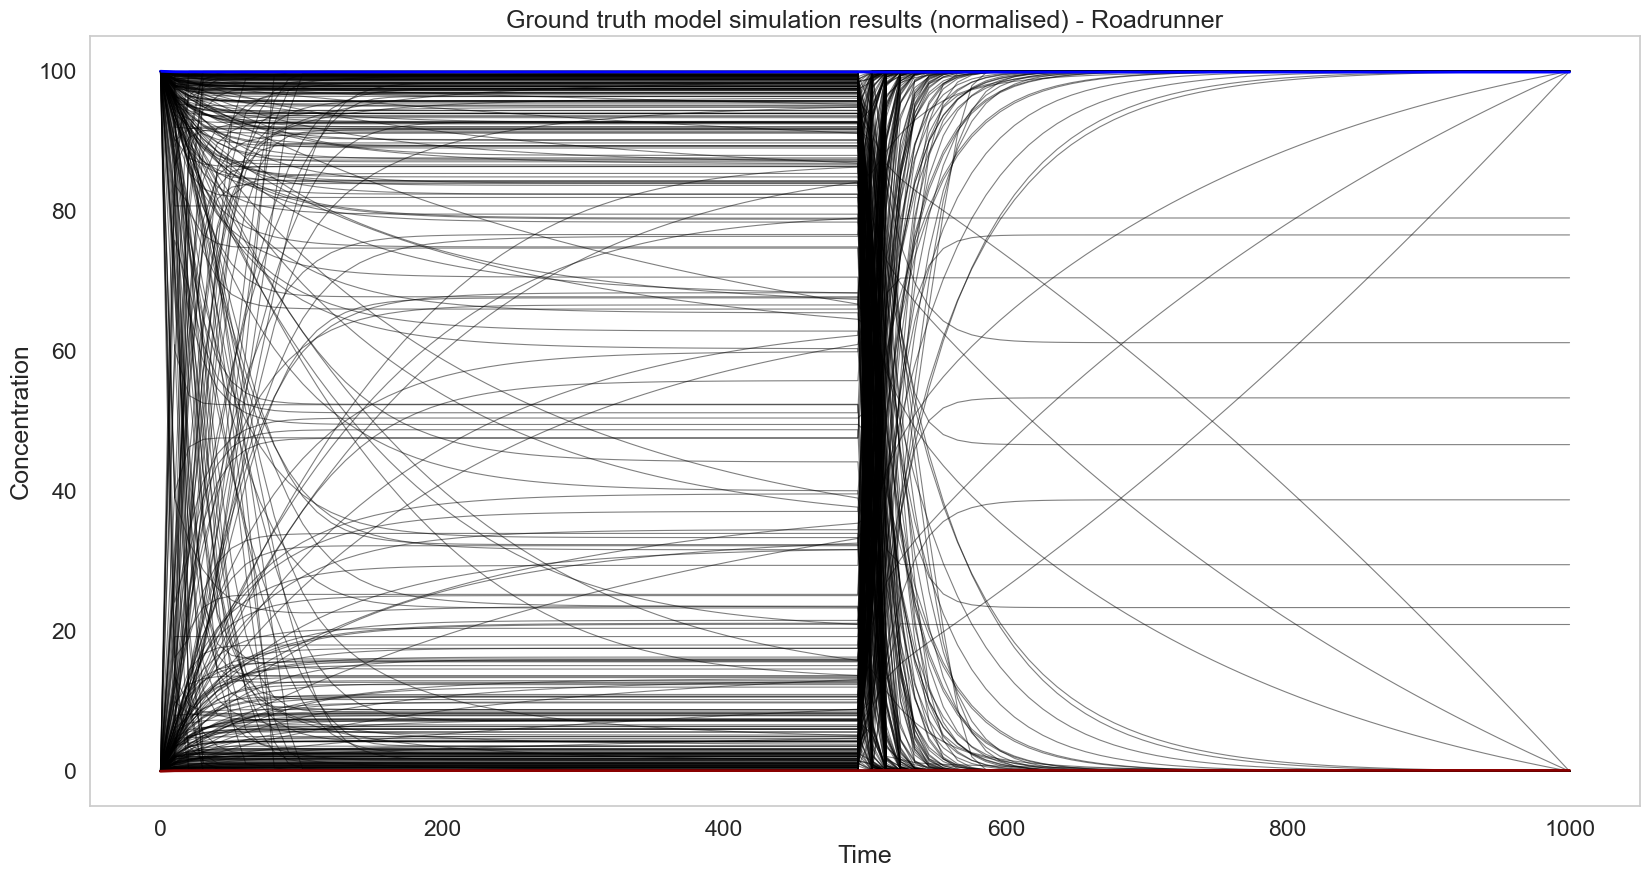

In [9]:
# use pandas default plot to plot the simulation results
import matplotlib.pyplot as plt
import seaborn as sns

states_variable_names = G0_d.get_state_variables()

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5)

# Plot the simulation results
plt.figure(figsize=(20, 10))

for state in states_variable_names:
    if state == 'C':
        plt.plot(result['time'], result[state], label=state, c='blue', linewidth=2)
    if state == 'Cp':
        plt.plot(result['time'], result[state], label=state, c='darkred', linewidth=2)
    else:
        # first process result[state] to normalise between 0 to 100 
        # and then plot it
        result[state] = (result[state] - result[state].min()) / (result[state].max() - result[state].min()) * 100
        plt.plot(result['time'], result[state], label=state, c='black', linewidth=0.8, alpha=0.5)
plt.title('Ground truth model simulation results (normalised) - Roadrunner')
plt.grid()
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
legend = plt.gca().get_legend()
if legend:
    legend.remove()
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.show()

### Generate synthetic 'omics-like' data

In [ ]:
from models.SyntheticGen import generate_feature_data, generate_target_data, generate_feature_data_v2

feature_data = generate_feature_data_v2(model_drug_spec, G0_d.get_state_variables(), feature_generation_method, feature_generation_extra_params, 1000, feature_generation_seed)
target_data, _ = generate_target_data(model_drug_spec, solver, feature_data, {'start': 0, 'end': 1000, 'points': 100}, n_cores=8)


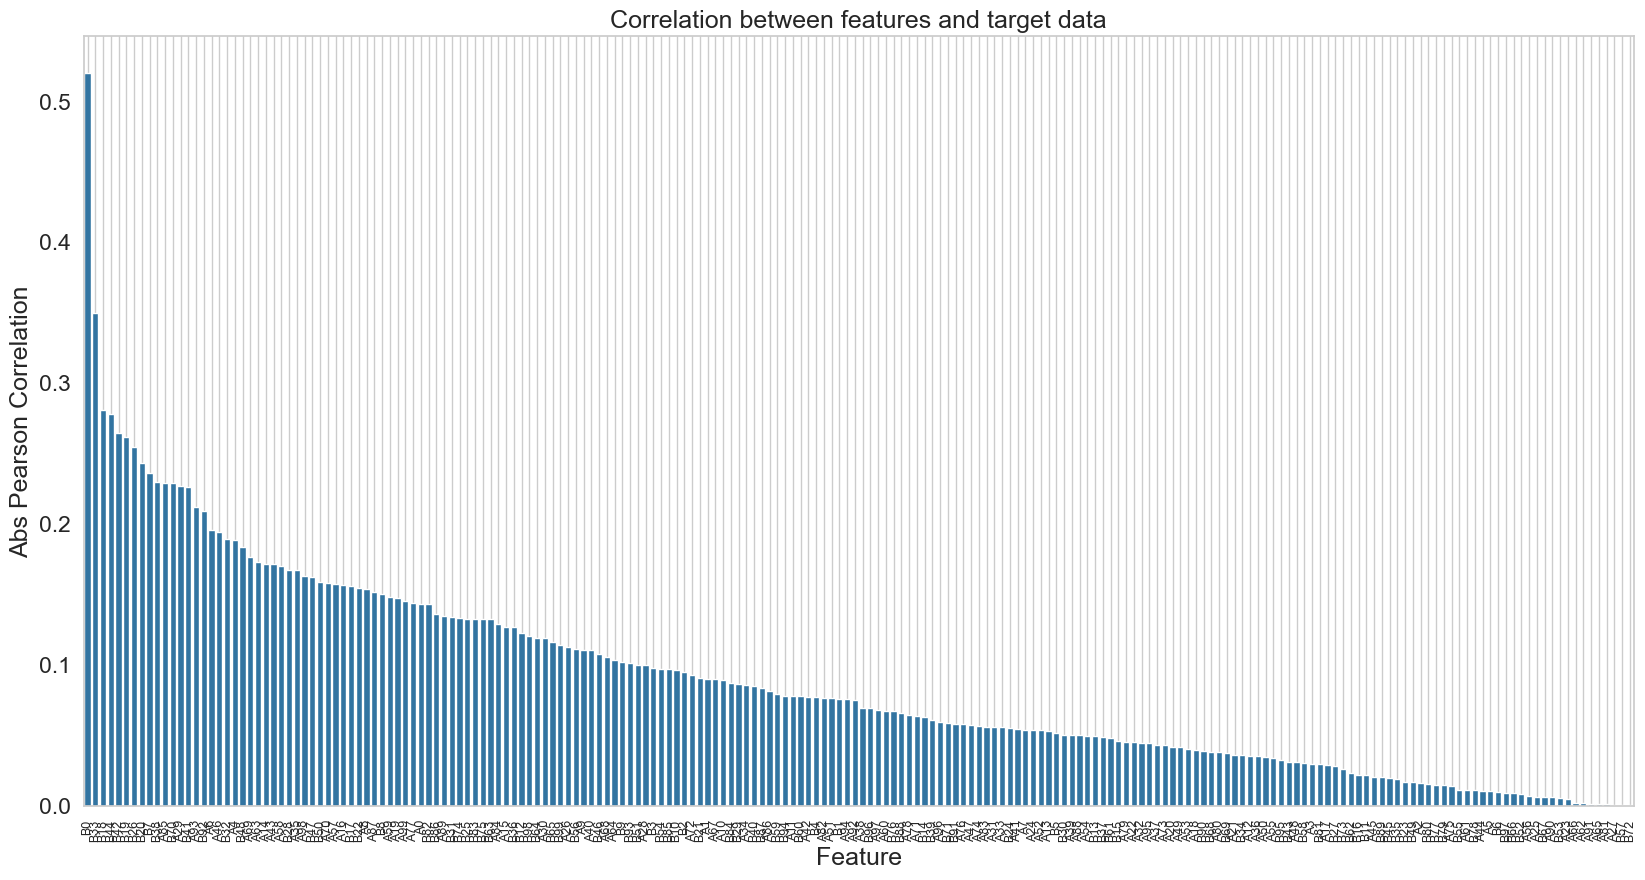

In [11]:
# plot the association between the features and the target data in a bar chart based on the correlation values 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# create a dataframe with the feature data and target data
feature_data_df = pd.DataFrame(feature_data)
target_data_df = pd.DataFrame(target_data)
# add the target data to the feature data
feature_data_df['target'] = target_data_df['Cp']

# calculate the correlation between the features and the target data
correlation = feature_data_df.corr()['target'].sort_values(ascending=False)
# create a dataframe with the correlation values
correlation_df = pd.DataFrame(correlation)
correlation_df = correlation_df.reset_index()
correlation_df.columns = ['feature', 'correlation']
# do not include the target data in the correlation dataframe
correlation_df = correlation_df[correlation_df['feature'] != 'target']
abs_correlation_df = correlation_df.copy()
# take the absolute value of the correlation
abs_correlation_df['correlation'] = abs(abs_correlation_df['correlation'])
# sort the dataframe by the absolute value of the correlation
abs_correlation_df = abs_correlation_df.sort_values(by='correlation', ascending=False)
# plot the correlation values
plt.figure(figsize=(20, 10))
sns.barplot(x='feature', y='correlation', data=abs_correlation_df)
plt.title('Correlation between features and target data')
plt.xlabel('Feature')
plt.ylabel('Abs Pearson Correlation')
plt.xticks(rotation=90, fontsize=9)
plt.grid()
plt.show()

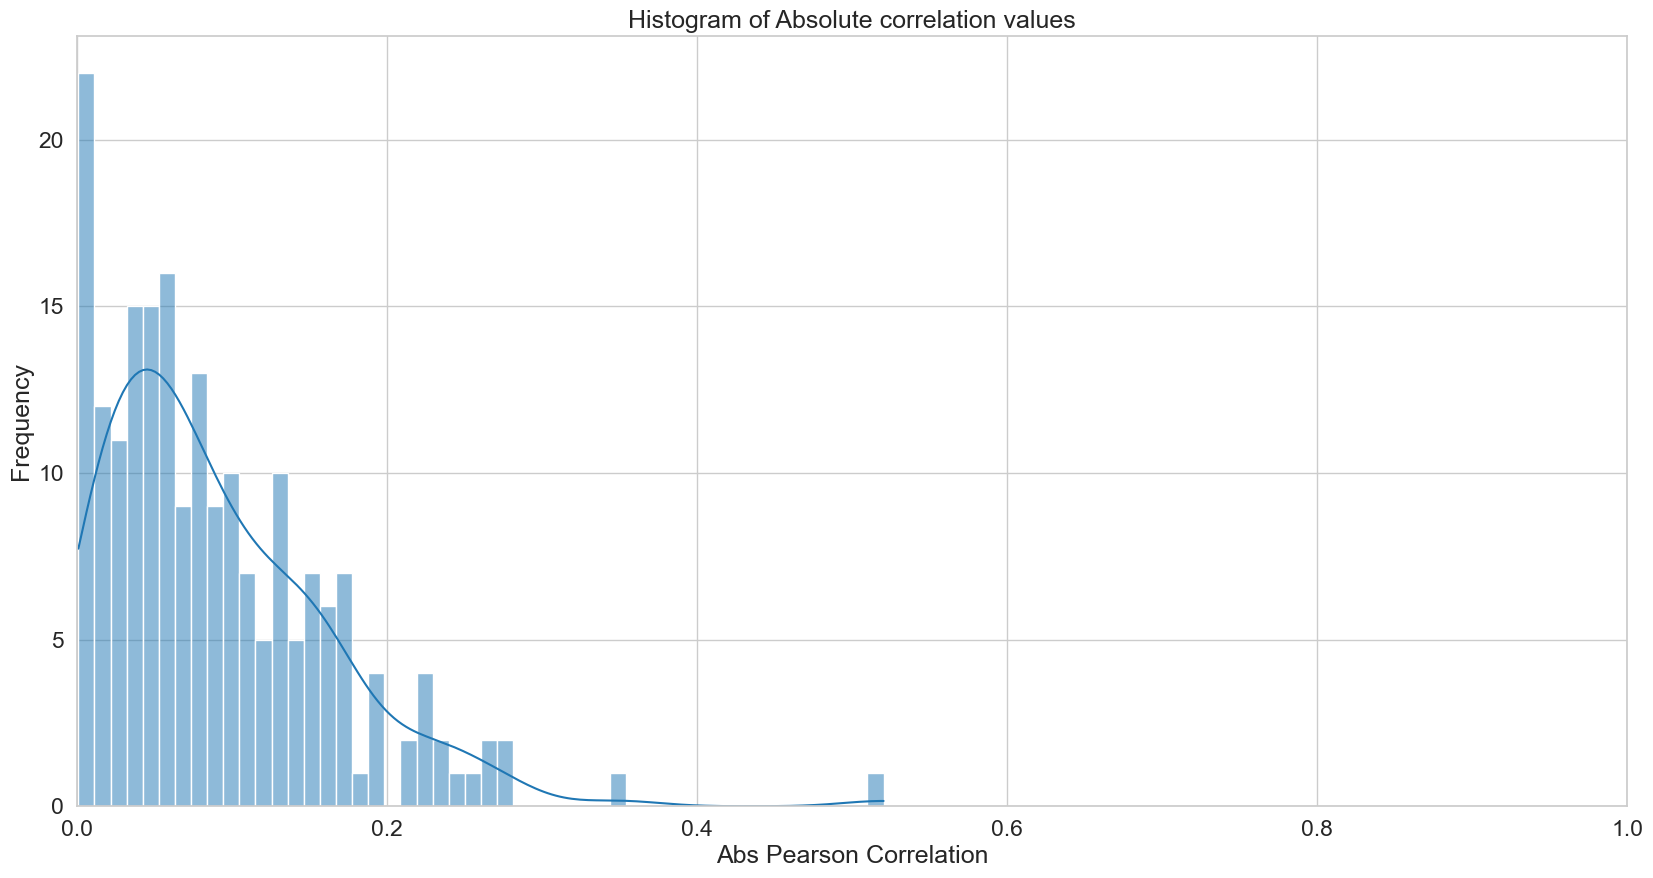

In [12]:
# make a histogram of the correlation values
plt.figure(figsize=(20, 10))
sns.histplot(abs_correlation_df['correlation'], bins=50, kde=True)
plt.title('Histogram of Absolute correlation values')
plt.xlabel('Abs Pearson Correlation')
plt.ylabel('Frequency')
plt.xlim(0,1)
plt.show()

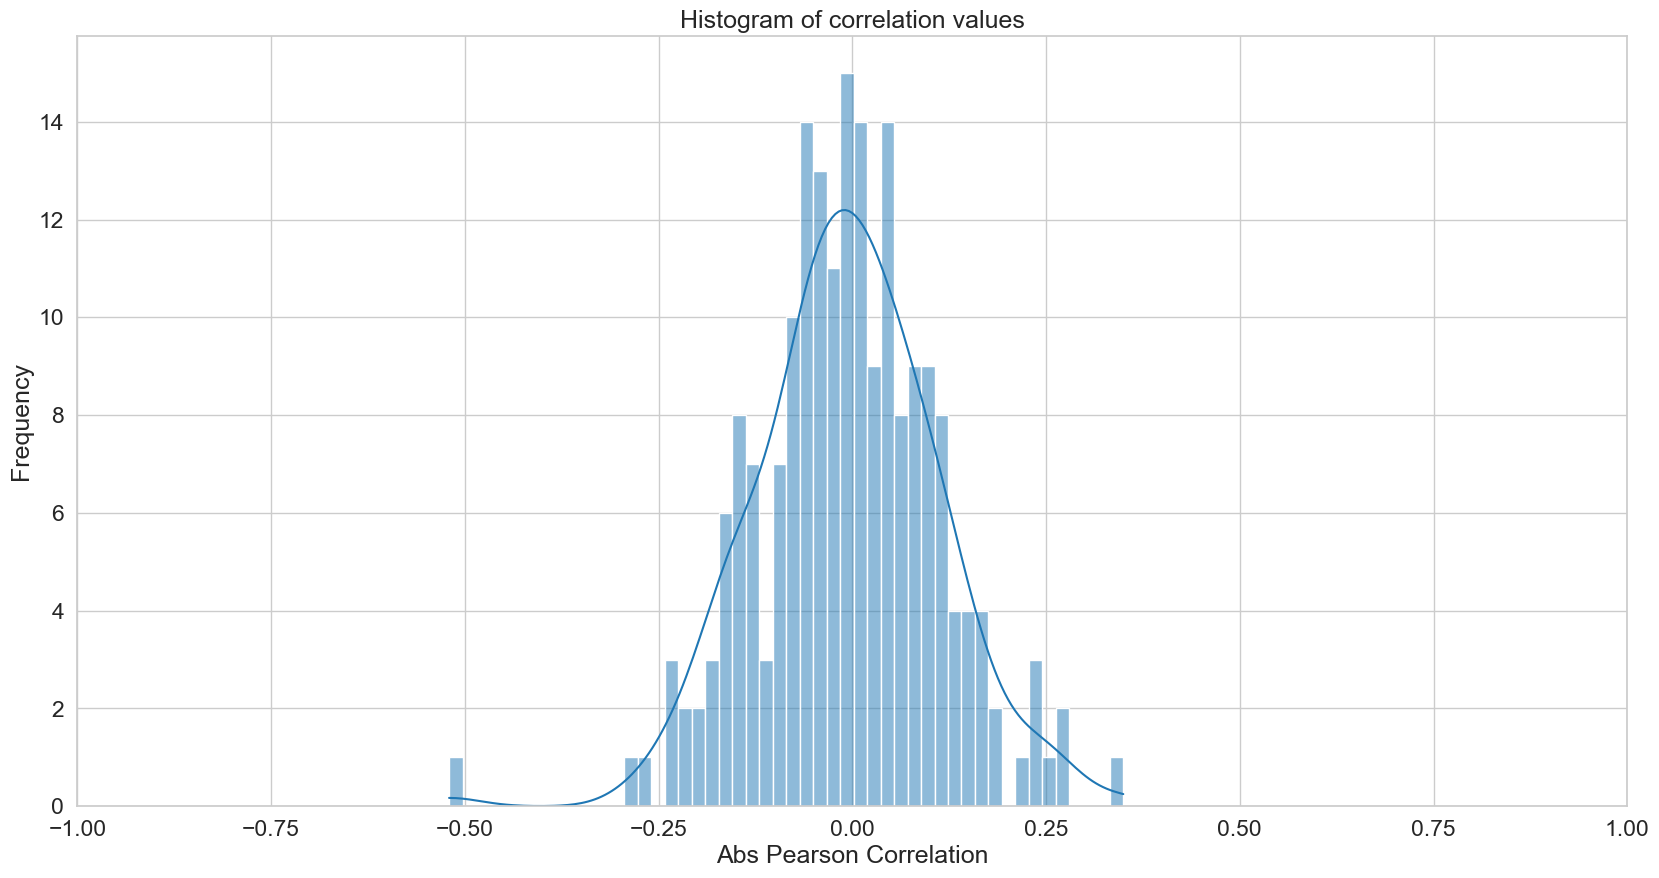

In [13]:
# make a histogram of the correlation values
plt.figure(figsize=(20, 10))
sns.histplot(correlation_df['correlation'], bins=50, kde=True)
plt.title('Histogram of correlation values')
plt.xlabel('Abs Pearson Correlation')
plt.ylabel('Frequency')
plt.xlim(-1,1)
plt.show()

In [14]:
# extract the mean and standard deviation of the correlation values
mean = np.mean(correlation_df['correlation'])
std = np.std(correlation_df['correlation'])
max_val = np.max(correlation_df['correlation'])
min_val = np.min(correlation_df['correlation'])
outliers = correlation_df[(correlation_df['correlation'] > mean + 3*std) | (correlation_df['correlation'] < mean - 3*std)]

print(f'Mean: {mean:.4f}')
print(f'Standard Deviation: {std:.4f}')
print(f'Max: {max_val:.4f}')
print(f'Min: {min_val:.4f}')
print(f'Outliers as a ratio of all features: {outliers.shape[0] / correlation_df.shape[0]:.4f}')

Mean: -0.0067
Standard Deviation: 0.1171
Max: 0.3497
Min: -0.5202
Outliers as a ratio of all features: 0.0100


10 features selected based on correlation with target data


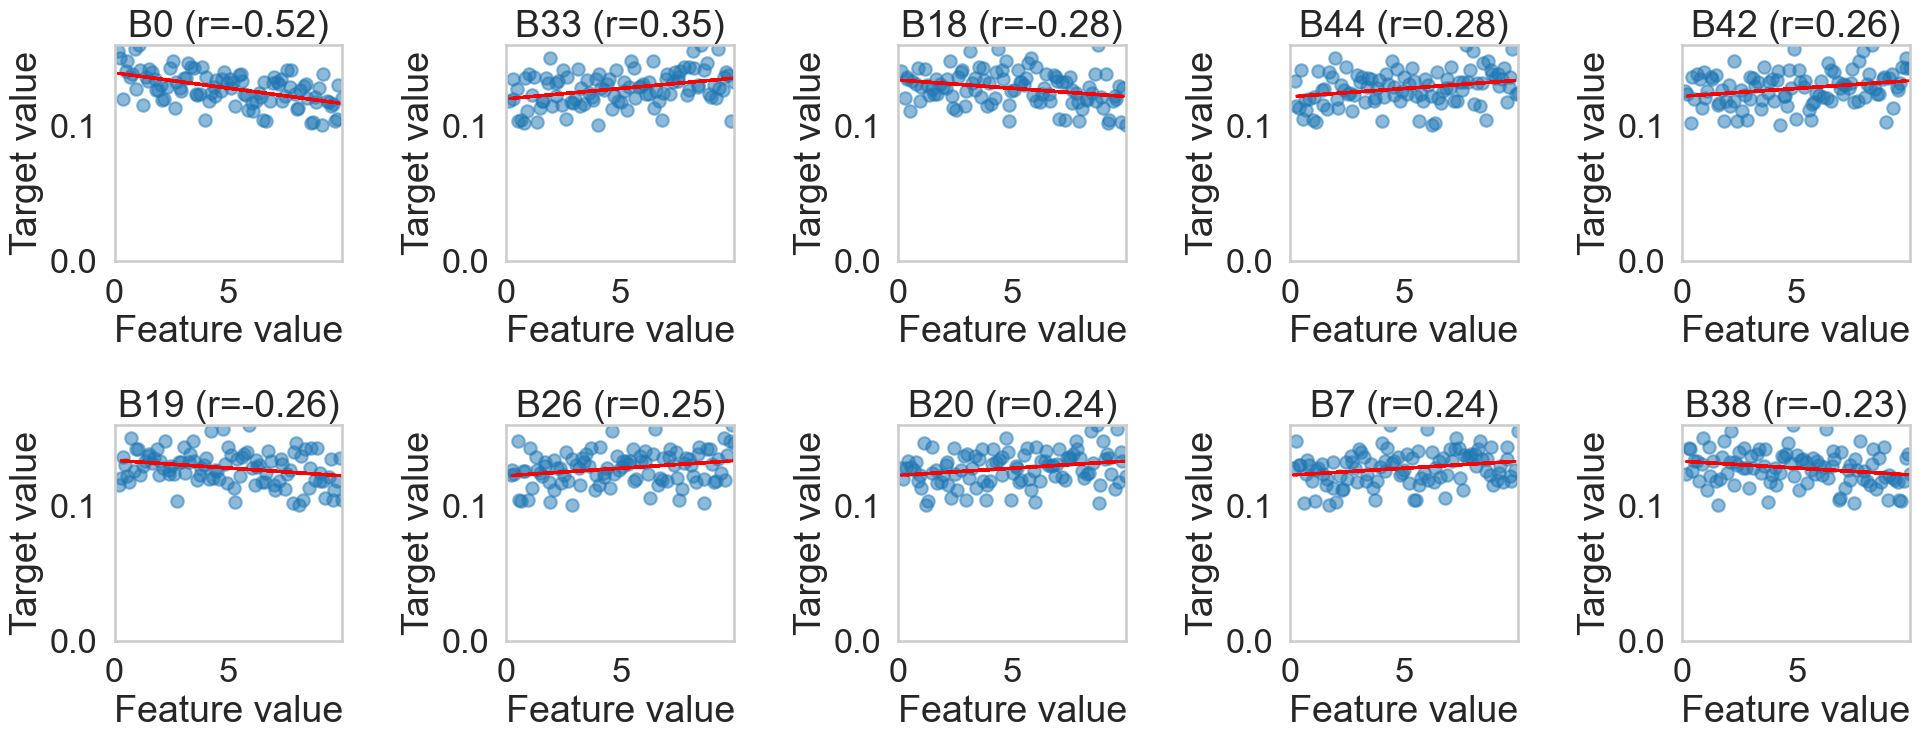

In [15]:
# plot association between the features and the target data 

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# for each feature, plot the association with the target data, which is only a series 
# plot all features in separate subplots
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1.5) 

n_features = len(feature_data.columns)
# plot only the top 10 features based on the absolute correlation values
top_features = abs_correlation_df['feature'].values[:10]
# create a new dataframe with only the top features
top_feature_data = feature_data[top_features]
print(f'{len(top_feature_data.columns)} features selected based on correlation with target data')
# make a subplot based on the size of feature_data, have five columns and as many rows as needed
top_n_features = len(top_feature_data.columns)
n_rows = int(top_n_features / 5) 
n_cols = 5
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, n_rows*4))
axs = axs.flatten()


# plot each feature in a separate subplot
for i, feature in enumerate(top_feature_data.columns):
    x = top_feature_data[feature].values.ravel()  # ensure 1D
    y = target_data.values.ravel()            # ensure 1D
    axs[i].scatter(x, y, alpha=0.5)
    # add a dash linear regression line with a pearson correlation coefficient
    # compute the pearson correlation coefficient
    corr, _ = pearsonr(x, y)
    # add a linear regression line
    model = LinearRegression()
    model.fit(x.reshape(-1, 1), y)
    y_pred = model.predict(x.reshape(-1, 1))
    axs[i].plot(x, y_pred, color='red', linestyle='--', linewidth=2)
    axs[i].set_title(f'{feature} (r={corr:.2f})')

    axs[i].set_xlabel('Feature value')
    axs[i].set_ylabel('Target value')
    axs[i].grid()
    # set the x and y limits to be the same for all subplots
    max_feature = top_feature_data[feature].values.max()   
    max_target = target_data.values.max()  
    axs[i].set_xlim([0,max_feature])
    axs[i].set_ylim([0,max_target])
    # compute the correlation between the feature and target data
plt.tight_layout()
plt.show()

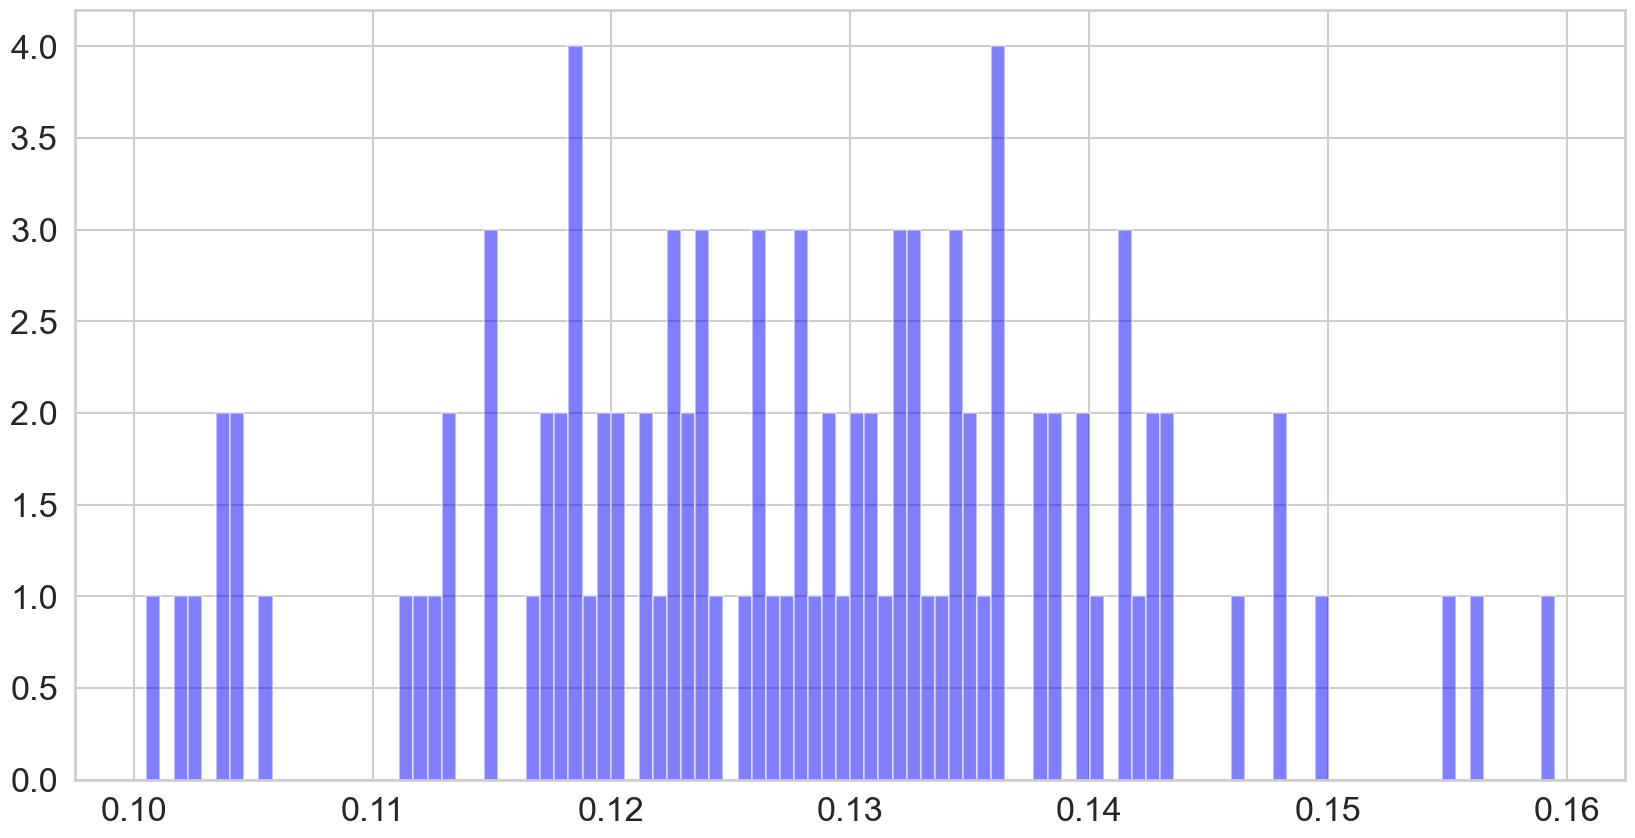

In [16]:
# plot the target data only with the x axis being 0 to 100 
plt.figure(figsize=(20, 10))
plt.hist(target_data, bins=100, alpha=0.5, color='blue')
plt.show()

### Suboptimal Model Creation

#### If modifying at the model architectural level

Mostly done to modify the `ModelSpec` object, where the updated spec information is transferred to a new `ModelBuilder` object, which then need to transpile to Antimony/SBML for a Solver instance. 

NewSpec --> NewBuilder --> Update parameters to original builder --> Transpile to Antimony/SBML --> Solver instance

#### If only changes to states and parameters are needed

Simply duplicate the `ModelBuilder` object and update the states and parameters.
```


In [54]:
# randomise links and parameters by using a different random seed

new_spec = DrugModelSpecification()
new_spec.generate_specifications(6, 15, 10, verbose=0)
drug_0 = Drug('D0', 500, 5000)
drug_0.add_regulation('A0', 'down')
drug_0.add_regulation('A1', 'down')
drug_0.add_regulation('A2', 'down')
new_spec.add_drug(drug_0)
print(new_spec)
print(f'Feedback: {new_spec.get_feedback_regulations()}')

A Species: ['A0', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14']
B Species: ['B0', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B13', 'B14']
C Species: ['C']
Regulations: [(np.str_('B10'), np.str_('A9')), (np.str_('B4'), np.str_('A10')), (np.str_('C'), np.str_('A10')), (np.str_('B14'), np.str_('B10')), (np.str_('B11'), np.str_('A13')), (np.str_('B10'), np.str_('B0')), (np.str_('B12'), np.str_('A14')), (np.str_('B1'), np.str_('A8')), (np.str_('B12'), np.str_('B5')), (np.str_('C'), np.str_('A2')), ('A0', 'B0'), ('A1', 'B1'), ('A2', 'B2'), ('A3', 'B3'), ('A4', 'B4'), ('A5', 'B5'), ('A6', 'B6'), ('A7', 'B7'), ('A8', 'B8'), ('A9', 'B9'), ('A10', 'B10'), ('A11', 'B11'), ('A12', 'B12'), ('A13', 'B13'), ('A14', 'B14'), ('B0', 'C'), ('B1', 'C'), ('B2', 'C'), ('B3', 'C'), ('B4', 'C'), ('B5', 'C'), ('B6', 'C'), ('B7', 'C'), ('B8', 'C'), ('B9', 'C'), ('B10', 'C'), ('B11', 'C'), ('B12', 'C'), ('B0', 'C'), ('B1', 'C'), ('D0', '

In [55]:
new_model = new_spec.generate_network('drug_model_552', specie_value_range, param_range, param_multiplier_range, random_seed=6, verbose=0)
new_base_parameters = new_model.get_parameters()
new_base_initial_conditions = new_model.get_state_variables()

In [56]:
new_solver = RoadrunnerSolver()
new_solver.compile(new_model.get_sbml_model())
new_result = new_solver.simulate(0, 1000, 100)

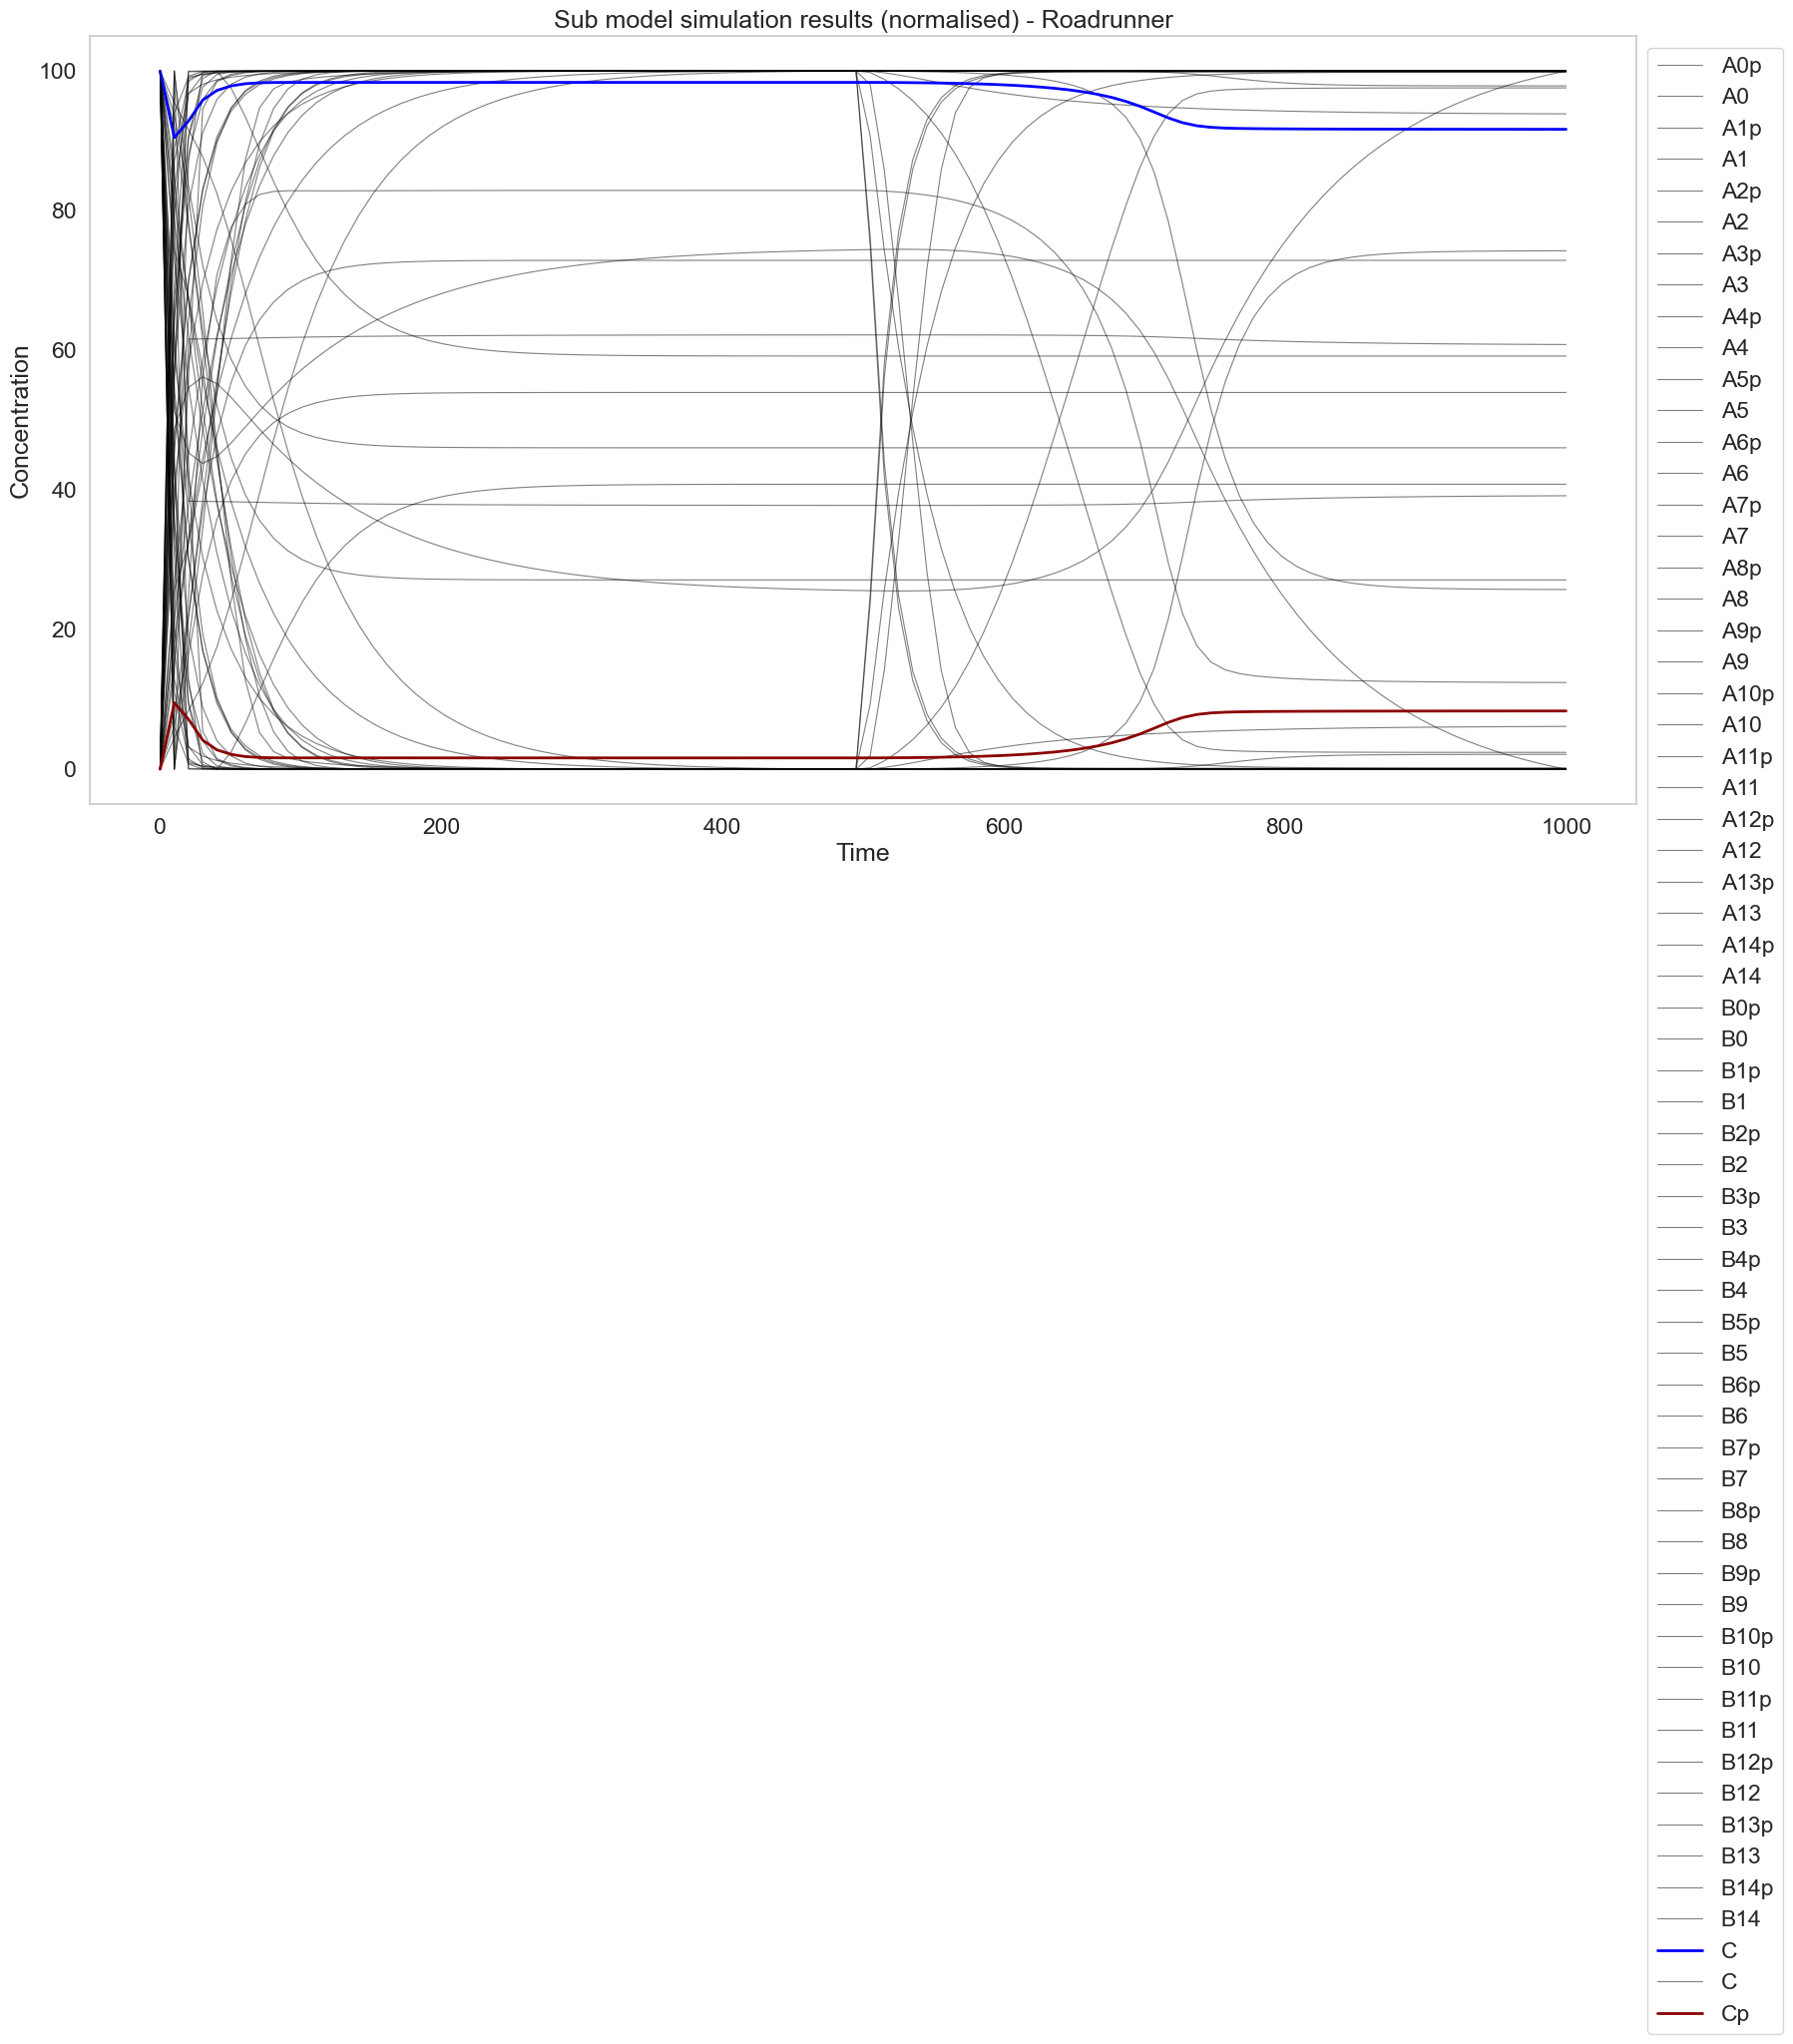

In [57]:
# use pandas default plot to plot the simulation results
import matplotlib.pyplot as plt
import seaborn as sns

states_variable_names = G0_d.get_state_variables()
result = new_result

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5)

# Plot the simulation results
plt.figure(figsize=(20, 10))

for state in states_variable_names:
    if state == 'C':
        plt.plot(result['time'], result[state], label=state, c='blue', linewidth=2)
    if state == 'Cp':
        plt.plot(result['time'], result[state], label=state, c='darkred', linewidth=2)
    else:
        # first process result[state] to normalise between 0 to 100 
        # and then plot it
        result[state] = (result[state] - result[state].min()) / (result[state].max() - result[state].min()) * 100
        plt.plot(result['time'], result[state], label=state, c='black', linewidth=0.8, alpha=0.5)
plt.title('Sub model simulation results (normalised) - Roadrunner')
plt.grid()
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.show()

### Simulation / Extract dynamic feature data

In [58]:
from models.SyntheticGen import generate_model_timecourse_data 

# generate the timecourse data for the new model
time_course_data = generate_model_timecourse_data(new_spec, 
                                                  new_solver, 
                                                  feature_data, 
                                                  {'start': 0, 'end': 1000, 'points': 100}, 
                                                  capture_species='all', n_cores=8)

























































































































100%|██████████| 1000/1000 [00:02<00:00, 366.13it/s]


In [59]:
from models.Utils import last_time_point_method, dynamic_features_method

all_species = new_spec.A_species + new_spec.B_species + new_spec.C_species
all_phos_species = [s+'p' for s in all_species]
# apply the data engineering method to the feature data
last_time_data = last_time_point_method(time_course_data, all_phos_species)

c:\Github\new-peak-project\src\models\Utils.py:804: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  last_time_points = selected_time_course_data.applymap(lambda x: x[-1])


In [60]:
dynamic_data = dynamic_features_method(time_course_data, all_phos_species, n_cores=8)










































































































100%|██████████| 1000/1000 [00:02<00:00, 441.40it/s]


In [61]:
combined_lp_data = pd.concat([feature_data, last_time_data], axis=1)
combined_dyn_data = pd.concat([feature_data, dynamic_data], axis=1)


In [62]:
feature_data_list = [feature_data, last_time_data, dynamic_data, combined_lp_data, combined_dyn_data]
feature_data_names = ['feature_data', 'last_time_data', 'dynamic_data', 'combined_lp_data', 'combined_dyn_data']

### Machine Learning Training

In [63]:
def evaluate_model(model, model_name, feature_data, feature_data_name, target_data ,test_size=0.2, random_state=4):
    X_train, X_test, y_train, y_test = train_test_split(feature_data, target_data, test_size=test_size, random_state=random_state)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    # return a dictionary of the model performance
    return {'Model': model_name, 
            'Feature Data': feature_data_name,
            'Mean Squared Error': mean_squared_error(y_test, y_pred),
            'R2 Score': r2_score(y_test, y_pred),
            'Pearson Correlation': pearsonr(y_test, y_pred)[0],
            'Pearson P-Value': pearsonr(y_test, y_pred)[1]
            }
# create a linear regression model
lm = LinearRegression()
# create a random forest model
rf = RandomForestRegressor(n_estimators=100, random_state=o_random_seed)
# create a gradient boosting model
gb = GradientBoostingRegressor(n_estimators=100, random_state=o_random_seed)
# create a support vector machine model
svr = SVR(max_iter=10000)
scaled_svr = Pipeline([('scaler', StandardScaler()), ('svr', svr)])
# create a neural network model (simple)
nn = MLPRegressor(hidden_layer_sizes=(20,), max_iter=10000, random_state=o_random_seed)
scaled_nn = Pipeline([('scaler', StandardScaler()), ('nn', nn)])

all_models = [lm, rf, gb, scaled_svr, scaled_nn]
all_models_desc = ['Linear Regression', 'Random Forest', 'Gradient Boosting', 'Support Vector Machine', 'Neural Network']
zipped_model_data = list(zip(all_models, all_models_desc))
all_features = feature_data_list
all_features_desc = feature_data_names
zipped_feature_data = list(zip(all_features, all_features_desc))

# random states are rand ints between 0 and 10000, for n values 
np.random.seed(o_random_seed)
n_random = 10
all_random_states = np.random.randint(0, 10000, n_random)

parallelise = True 
from tqdm import tqdm
# tqdm is a progress bar library, use it to show the progress of the model evaluation
metric_data = []
if not parallelise:          
    for (feature_data, feature_data_name) in tqdm(zipped_feature_data):
        # print('Feature Data:', feature_data_name)
        # print('Feature Data Shape:', feature_data.shape)
        for (model, model_name) in zipped_model_data:
            # print('Model:', model_name)
            for rand in all_random_states:
                metrics = evaluate_model(model, model_name, feature_data, feature_data_name, target_data['Cp'], random_state=rand)
                metric_data.append(metrics)
                
else:        
    # parallelise the model evaluation process using joblib
    from joblib import Parallel, delayed

    metric_data = Parallel(n_jobs=-1)(delayed(evaluate_model)(model, model_name, feature_data, feature_data_name, target_data['Cp'], random_state=rand) 
                                    for (feature_data, feature_data_name) in zipped_feature_data
                                    for (model, model_name) in zipped_model_data
                                    for rand in all_random_states)

# make a dataframe of the metric data
metric_df = pd.DataFrame(metric_data)
metric_df

,Model,Feature Data,Mean Squared Error,R2 Score,Pearson Correlation,Pearson P-Value
0,Linear Regression,feature_data,41.817236,0.763497,0.879876,6.763664e-66
1,Linear Regression,feature_data,42.643939,0.802853,0.896688,5.278796e-72
2,Linear Regression,feature_data,41.385236,0.821525,0.907413,1.767909e-76
3,Linear Regression,feature_data,44.039537,0.827056,0.911492,2.512105e-78
4,Linear Regression,feature_data,40.090469,0.803486,0.896718,5.134919e-72
...,...,...,...,...,...,...
245,Neural Network,combined_dyn_data,77.454609,0.649903,0.839320,2.626808e-54
246,Neural Network,combined_dyn_data,102.631245,0.549179,0.800434,6.910587e-46
247,Neural Network,combined_dyn_data,115.046339,0.559972,0.843755,2.077186e-55
248,Neural Network,combined_dyn_data,66.590191,0.676956,0.861604,3.213733e-60


In [64]:
if save_figures: 
    metric_df.to_pickle(experiment_folder+'metric_df.pkl')
    print('Metric data saved to:', experiment_folder+'metric_df.pkl')   


Metric data saved to: I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\new-peak-project\experiments/exp5_drug_model_6_60_50/metric_df.pkl


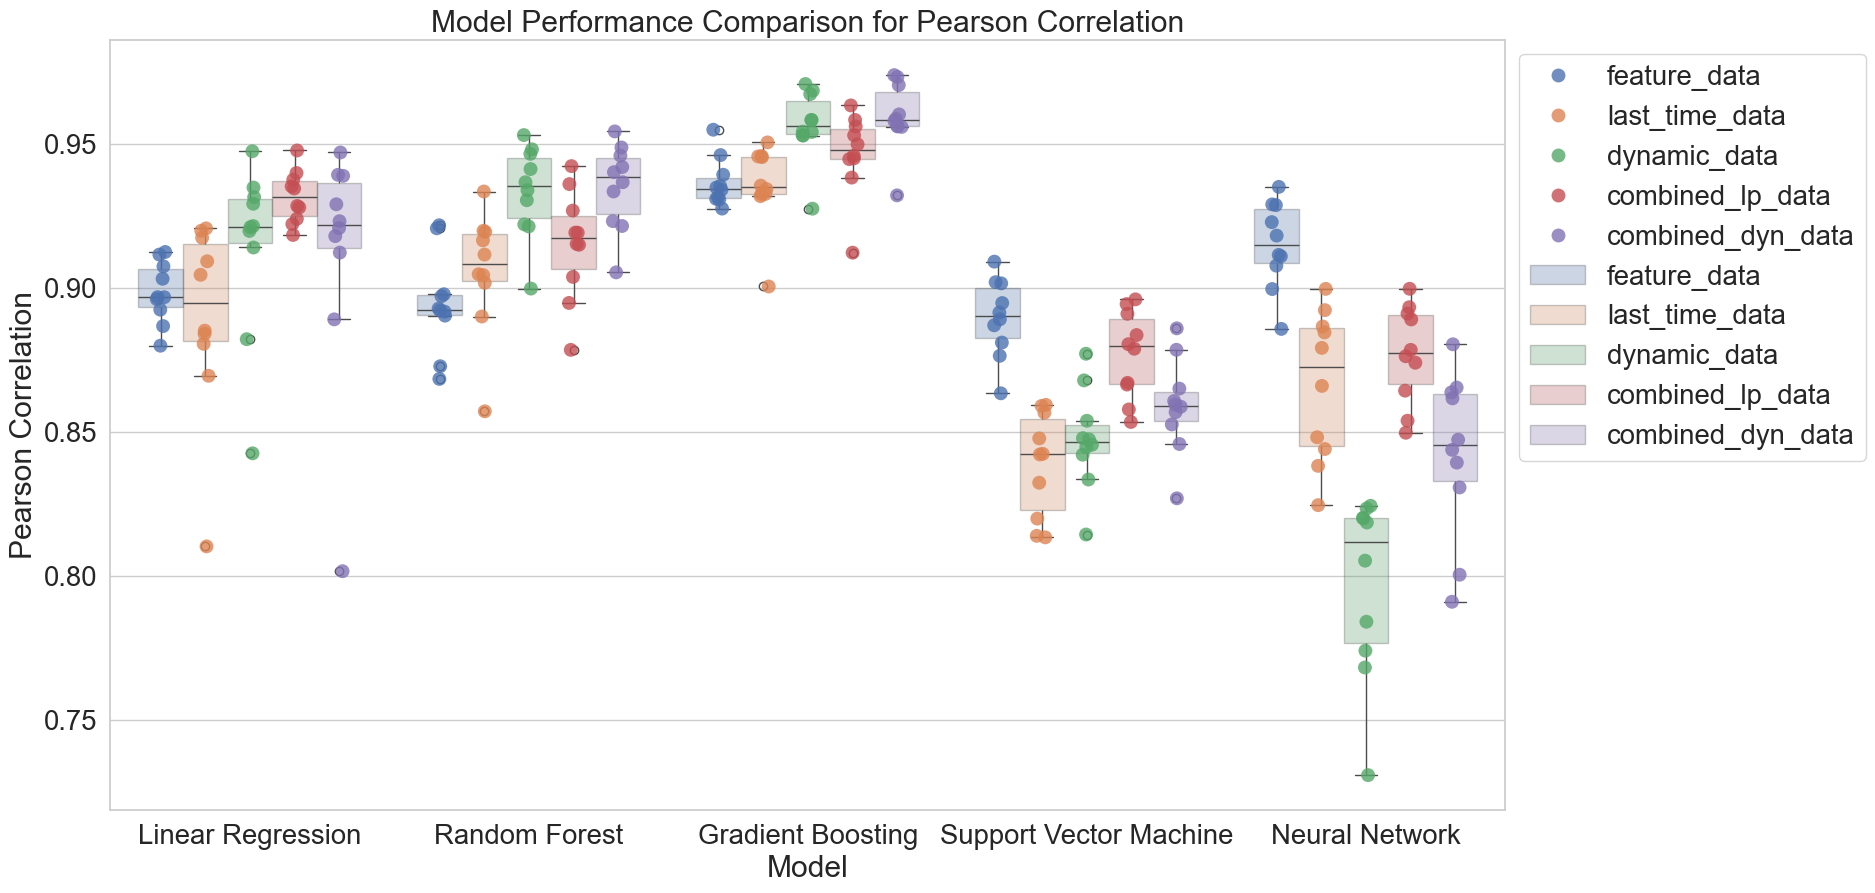

In [65]:
# create box plots for each model type and feature data type, plot for pearson correlation

sns.set(rc={'figure.figsize':(18,10)})
# make the font size bigger for labels and title, and axes labels 
sns.set(font_scale=1.8)
sns.set_style("whitegrid")
sns.stripplot(data=metric_df, x='Model', y='Pearson Correlation', hue='Feature Data', dodge=True, jitter=True, size=10, alpha=0.8)

# display the mean value for each model and feature data type
mean_vals = metric_df.groupby(['Model', 'Feature Data']).mean().reset_index()
    

# make a transparent box plot, without using the alpha parameter
sns.boxplot(data=metric_df, x='Model', y='Pearson Correlation', hue='Feature Data')
for patch in plt.gca().patches:
    patch.set_alpha(0.3)

plt.title('Model Performance Comparison for Pearson Correlation')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

if save_figures:
    plt.savefig(experiment_folder + 'Fig_13_model_performance_comparison_pearson.png')
plt.show()

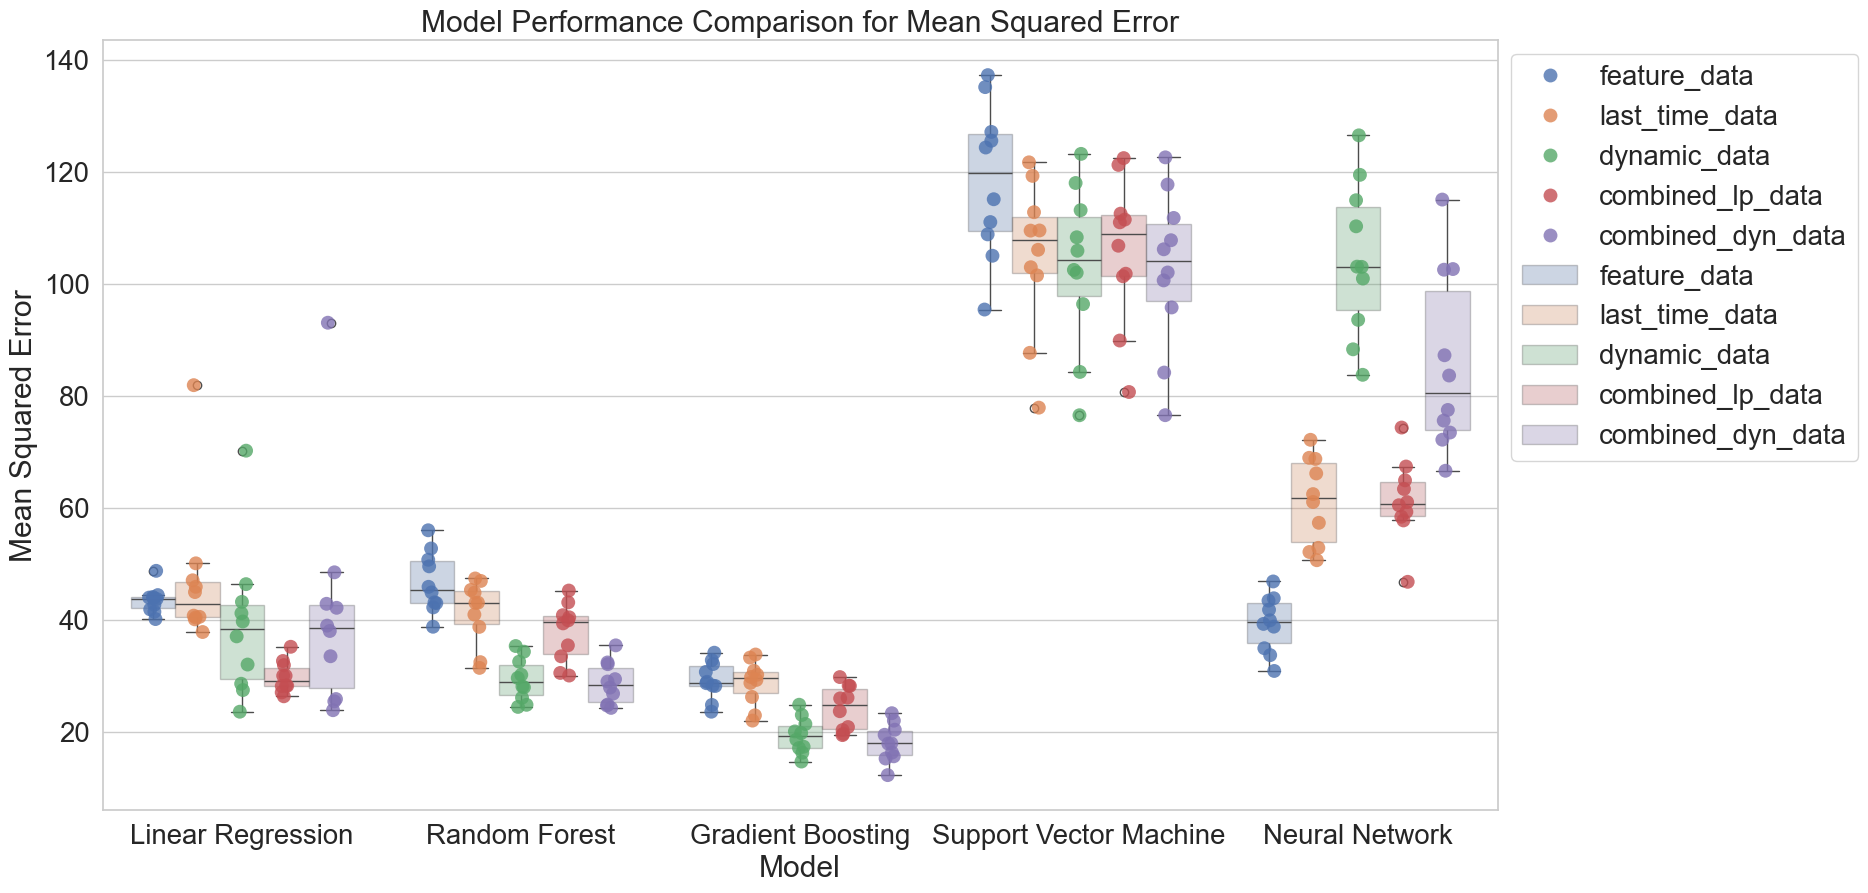

In [66]:
# create box plots for each model type and feature data type, plot for pearson correlation

sns.set(rc={'figure.figsize':(18,10)})
# make the font size bigger for labels and title, and axes labels 
sns.set(font_scale=1.8)
sns.set_style("whitegrid")
sns.stripplot(data=metric_df, x='Model', y='Mean Squared Error', hue='Feature Data', dodge=True, jitter=True, size=10, alpha=0.8)

# make a transparent box plot, without using the alpha parameter
sns.boxplot(data=metric_df, x='Model', y='Mean Squared Error', hue='Feature Data')
for patch in plt.gca().patches:
    patch.set_alpha(0.3)

plt.title('Model Performance Comparison for Mean Squared Error')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

if save_figures:
    plt.savefig(experiment_folder + 'Fig_14A_all_model_performance_comparison_mse.png')
plt.show()